 # **Skin Lesion Classification Using Fine-Tuned Neural Networks**


###**Determining Cancers from Digital Images**

### Visual Classification is a new a promising method of determining the threats of diseases and illnesses that can be optically detected on the surface of the skin or through CT Scans and XRays. In practice, automated detection of these deformities through image analysis is more effective and time efficient than manual diagnosis, cutting costs and resources as well.

### Skin deformations such as skin lesions are indicative of underlying conditions are can be used to predict skin cancers in various stages, many which prove to be fatal when left undiagnosed. Skin cancers such as melanoma and carcinoma are among the highest mortality rate cancers in clinical study. Though these skin cancers are so dangerous, they are often conflated with benign skin lesions that have no effect on health.

###This classification model was created to improve the accuracy of skin lesion classification, creating a more effective method for determining skin cancers from images.


###**1.** Our first step is to import the necessary libraries. The primary libraries we'll be using are : Numpy for Arrays and Math, Pandas for data analysis, PyTorch Framework, Matplotlib, PIL for images and Seaborn for Visualizations.



In [1]:
import os
import glob
import pandas as pd
import numpy as np
from torchvision import *
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

drive.mount("/content/drive")
data_dir = '/content/drive/MyDrive/CV Project/data'

Mounted at /content/drive


 ### **2.** The data is read using ```read_csv``` and stored in an array of the skin images. Each object represents a image from skin lesion site. Afteward the images are visualized and the corresponding dataframe is plotted.

In [ ]:
# Reading the data
image_path = glob.glob(os.path.join(data_dir,'*','*.jpg'))
skin_df = pd.read_csv(data_dir + '/HAM10000_metadata.csv')

skin_images = []
for path in image_path: 
  skin_images.append(cv2.imread(path))


In [ ]:
image_path[:7]

['/content/drive/MyDrive/CV Project/data/HAM10000_images_part_2/ISIC_0033320.jpg',
 '/content/drive/MyDrive/CV Project/data/HAM10000_images_part_2/ISIC_0033318.jpg',
 '/content/drive/MyDrive/CV Project/data/HAM10000_images_part_2/ISIC_0033313.jpg',
 '/content/drive/MyDrive/CV Project/data/HAM10000_images_part_2/ISIC_0033347.jpg',
 '/content/drive/MyDrive/CV Project/data/HAM10000_images_part_2/ISIC_0033327.jpg',
 '/content/drive/MyDrive/CV Project/data/HAM10000_images_part_2/ISIC_0033353.jpg',
 '/content/drive/MyDrive/CV Project/data/HAM10000_images_part_2/ISIC_0033342.jpg']

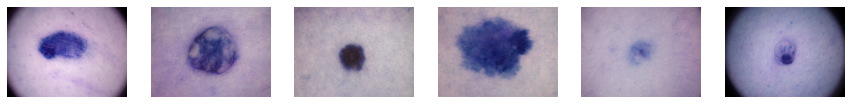

In [ ]:
# Visualizing the images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(skin_images[i])
    plt.axis('off')
plt.show()

In [ ]:
# Dataframe summary
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


### **3.** The images are then indexed and and matched to corresponding labels. 

```
for i in range(len(image_path)):
  image_id = os.path.basename(image_path[i]).replace('.jpg', '')
  skin_df.loc[skin_df['image_id'] == image_id, 'image_index'] = i
```
### The corresponding metdata is displayed in the dataframe.



In [ ]:
# Converting skin cancer types to integer labels
skin_df['label'] = pd.Categorical(skin_df['dx']).codes

# Match images to labels
skin_df['image_index'] = None
for i in range(len(image_path)):
  image_id = os.path.basename(image_path[i]).replace('.jpg', '')
  skin_df.loc[skin_df['image_id'] == image_id, 'image_index'] = i

skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,image_index
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,6130
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,9657
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,7509
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,8347
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,2270


### **4.** Next, the images are processed to remove noise from the and normalize the image sizes using  OpenCV. 


```
 grayscaleImage =  cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
```
### The color is made consistent across all of the image files and the images are dilated and have extranious noise removed. Thee output is produced below.




# Preprocessing

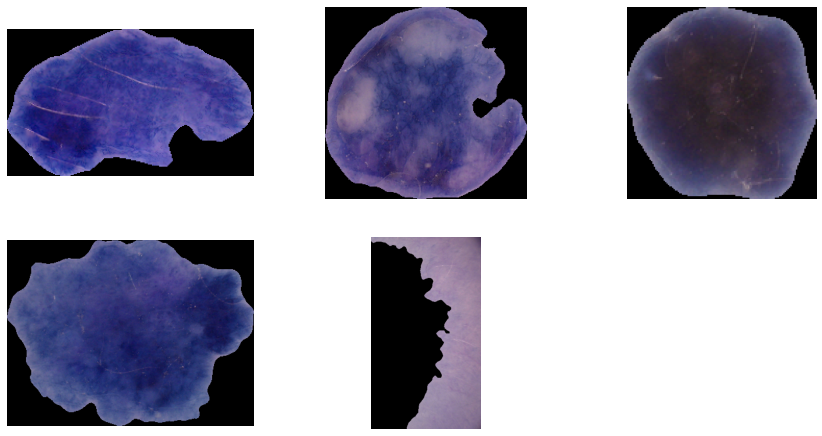

In [ ]:
def preprocessing(Image):
  grayscaleImage =  cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)

  #removing noise such as hair  using dull razor and opening
  kernel = cv2.getStructuringElement(1, (17, 17))
  blackhat = cv2.morphologyEx(grayscaleImage, cv2.MORPH_BLACKHAT, kernel)
  ret, thresh2 = cv2.threshold(blackhat, 20, 255, cv2.THRESH_BINARY)
  dst = cv2.inpaint(Image, thresh2, 3.5, cv2.INPAINT_TELEA)
  grayImage = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
  ret, thresh =  cv2.threshold(grayImage,10,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  kernel = np.ones((3,3),np.uint8)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

  #dilation 
  dilate = cv2.dilate(opening,kernel,iterations=2)

  #find countours
  blur = cv2.blur(dilate,(15,15))
  ret, thresh =  cv2.threshold(blur,20,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  cnt = max(contours, key=cv2.contourArea)

  #segment lesions
  h, w = dst.shape[:2]
  mask = np.zeros((h, w), np.uint8)
  cv2.drawContours(mask, [cnt],-1, 255, -1)
  res = cv2.bitwise_and(dst, dst, mask=mask)

  #extract ROI
  x,y,w,h = cv2.boundingRect(cnt)
  ROI = res[y:h+y,x:w+x]

  return ROI

ImageList = []
for i in range(6):
  ImageList.append(preprocessing(skin_images[i]))

# Visualizing the images
plt.figure(figsize=(15,12))
for i in range(1,6):
    plt.subplot(3,3,i)
    plt.imshow(ImageList[i])
    plt.axis('off')
plt.show()

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


### **4.a** All images are processed and the dataframe is saved as simple csv file.

In [ ]:
# Preprocess all images
for i in range(len(skin_images)):
  input_tensor = preprocessing(skin_images[i])
  input_tensor = preprocess(Image.fromarray(input_tensor))
  input_batch = input_tensor.unsqueeze(0)
  torch.save(input_batch, data_dir + '/Preprocessed/' + str(i) + '.pt')  # Save images according to their index
  #print("input image ", i," shape ",input_tensor.shape)

In [ ]:
# Save dataframe
skin_df.to_csv(data_dir + '/Preprocessed.csv')

# Model Initialization

### **5.** The model is initialized for labels (y) and data (x).

```
 def __init__(self, list_IDs, labels, device):
```



In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, device):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.device = device

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, ID):
        'Generates one sample of data'

        # Load data and get label
        X = torch.load(data_dir + '/Preprocessed/' + str(ID) + '.pt')[0]
        y = self.labels[ID]

        return X, y

In [ ]:
# Specify device
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Use GPU where possible
print(device)

# Load dataframe
skin_df = pd.read_csv(data_dir + '/Preprocessed.csv')

# Parameters
params = {'batch_size': 64}
          #'num_workers': 2}
max_epochs = 25
training_size = 0.8

# Attach labels to images
labels = {}
for i in range(skin_df.shape[0]):
  labels[skin_df.loc[i, 'image_index']] = skin_df.loc[i, 'label']

cuda


### **6.** We check for imbalances across the classes and plot and add weights required. The data is then loaded for training. 

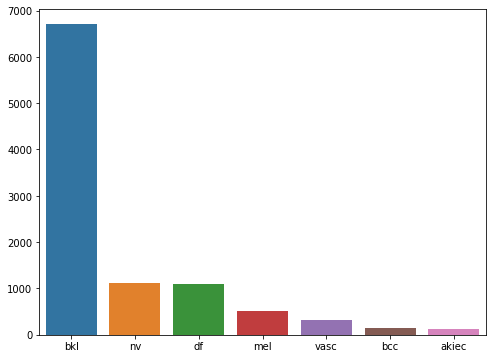

In [ ]:
# Checking for class imbalance
type_cancer = skin_df['dx'].unique()
counts = list(skin_df['dx'].value_counts())
plt.figure(figsize = (8,6))
sns.barplot(x = type_cancer, y = counts)

In [ ]:
# Creating weighted random sampler to balance out the classes
counts = np.bincount(skin_df['label'])
labels_weights = 1. / counts
weights = labels_weights[skin_df['label']]
train_weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights[:int(len(weights)*training_size)], int(len(weights)*training_size))
valid_weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights[int(len(weights)*training_size)+1:], int(len(weights)*(1-training_size)))

In [ ]:
# Data loaders
training_set = Dataset(skin_df.loc[:int(skin_df.shape[0]*training_size), 'image_index'], labels, device)
training_generator = torch.utils.data.DataLoader(training_set, **params, sampler=train_weighted_sampler)

validation_set = Dataset(skin_df.loc[int(skin_df.shape[0]*training_size)+1:, 'image_index'], labels, device)
validation_generator = torch.utils.data.DataLoader(validation_set, **params, sampler=valid_weighted_sampler)

In [ ]:
# Resnet50 model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)  # Output layer size = 7
model = model.to(device)
#print(model)

criterion = nn.CrossEntropyLoss()           # To calculate cross entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

# Model Training

### **7.** Here the data is trained, resulting in a fine-tuned model. Each epoch represents a phase in which a new iteration is run.

In [ ]:
def train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs=max_epochs):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dataloaders = {}
        dataloaders['train'] = train_dataloader
        dataloaders['valid'] = valid_dataloader

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### **8.** The fine tuing model is saved and stored for final evaluation.



```
torch.save(model_ft.state_dict(), data_dir + '/Model2/model.pth')
```





In [ ]:
import time
import copy
model_ft, hist = train_model(model, training_generator, validation_generator, criterion, optimizer, num_epochs=max_epochs)

In [ ]:
# Save Model
torch.save(model_ft.state_dict(), data_dir + '/Model2/model.pth')

# Model Evaluation

### **9.** The preprocessed is then loaded. The original and Fine-Tuned models are loaded for comparison. Using Pytorch is loaded and labels are attached.  

In [2]:
# Specify device
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Use GPU where possible
print(device)

# Load dataframe
skin_df = pd.read_csv(data_dir + '/Preprocessed.csv')

# Load original model
orig_model = models.resnet50(pretrained=True)
orig_model.fc = nn.Linear(orig_model.fc.in_features, 7)  # Output layer size = 7
orig_model.eval()
orig_model = orig_model.to(device)

# Load fine-tuned model
ft_model = models.resnet50(pretrained=True)
ft_model.fc = nn.Linear(ft_model.fc.in_features, 7)
ft_model.load_state_dict(torch.load(data_dir + '/Model1/model.pth'))
ft_model.eval()
ft_model = ft_model.to(device)

cuda


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [3]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, device):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.device = device

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, ID):
        'Generates one sample of data'

        # Load data and get label
        X = torch.load(data_dir + '/Preprocessed/' + str(ID) + '.pt')[0]
        y = self.labels[ID]

        return X, y, ID

# Attach labels to images
labels = {}
for i in range(skin_df.shape[0]):
  labels[skin_df.loc[i, 'image_index']] = skin_df.loc[i, 'label']

# Validation set
training_size = 0.8
validation_set = Dataset(skin_df.loc[int(skin_df.shape[0]*training_size)+1:, 'image_index'], labels, device)
validation_generator = torch.utils.data.DataLoader(validation_set, shuffle=False, batch_size=64)
#print(len(skin_df.loc[int(skin_df.shape[0]*training_size)+1:, 'image_index']))

#Confusion Matrix

### **10.** A confusion matrix is created using Scikit-Learn. 

In [4]:
# Get validation results
from sklearn import metrics
def valid_model(model, valid_dataloader):
  matrix = 0
  incorrect = {}
  incorrect['image'] = []
  incorrect['actual'] = []
  incorrect['pred'] = []
  for local_batch, local_labels, id in valid_dataloader:
    # Validation
    with torch.set_grad_enabled(False):
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            outputs = model(local_batch)
            _, preds = torch.max(outputs, 1)
            abc = np.array(preds.to('cpu'))
            wow = np.array(local_labels.to('cpu'))
            matrix += metrics.confusion_matrix(wow, abc, labels=[0,1,2,3,4,5,6])
            incorrect['image'] += id[wow != abc]
            incorrect['actual'] += local_labels[wow != abc]
            incorrect['pred'] += preds[wow != abc]
            #print("stillgoing")
  return matrix, incorrect

### **11.** The-fine tuned model proved to be significantly more successful, with higher accuracy and precision than the original model.


The fine tuned model produced an overall accuracy of 0.998


In [5]:
# Original Model
matrix, incorrect = valid_model(orig_model, validation_generator)
print(matrix)

[[  9   2   0   0   0   5   9]
 [ 36   8   0   0   7   2  25]
 [ 57  19   0   0  23  13 114]
 [  7   1   0   0   3   0  10]
 [155  25   0   0  37  14 204]
 [433  71   0   1 122  17 536]
 [ 13   2   0   0   0   1  21]]


In [15]:
# Compute tp, tp_and_fn and tp_and_fp w.r.t all classes
tp_and_fn = matrix.sum(1)
tp_and_fp = matrix.sum(0)
tp = matrix.diagonal()

precision = tp / tp_and_fp
recall = tp / tp_and_fn
print(pd.DataFrame([precision, recall], ['Precision', 'Recall']))

                  0         1    2    3         4         5         6
Precision  0.012676  0.062500  NaN  0.0  0.192708  0.326923  0.022851
Recall     0.360000  0.102564  0.0  0.0  0.085057  0.014407  0.567568


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [16]:
# Fine-Tuned Model
matrix, incorrect = valid_model(ft_model, validation_generator)
print(matrix)

[[  25    0    0    0    0    0    0]
 [   0   78    0    0    0    0    0]
 [   0    0  226    0    0    0    0]
 [   0    0    1   18    0    1    1]
 [   0    0    0    0  435    0    0]
 [   0    0    0    0    1 1179    0]
 [   0    0    0    0    0    0   37]]


In [17]:
# Compute tp, tp_and_fn and tp_and_fp w.r.t all classes
tp_and_fn = matrix.sum(1)
tp_and_fp = matrix.sum(0)
tp = matrix.diagonal()

precision = tp / tp_and_fp
recall = tp / tp_and_fn
print(pd.DataFrame([precision, recall], ['Precision', 'Recall']))

             0    1         2         3         4         5         6
Precision  1.0  1.0  0.995595  1.000000  0.997706  0.999153  0.973684
Recall     1.0  1.0  1.000000  0.857143  1.000000  0.999153  1.000000


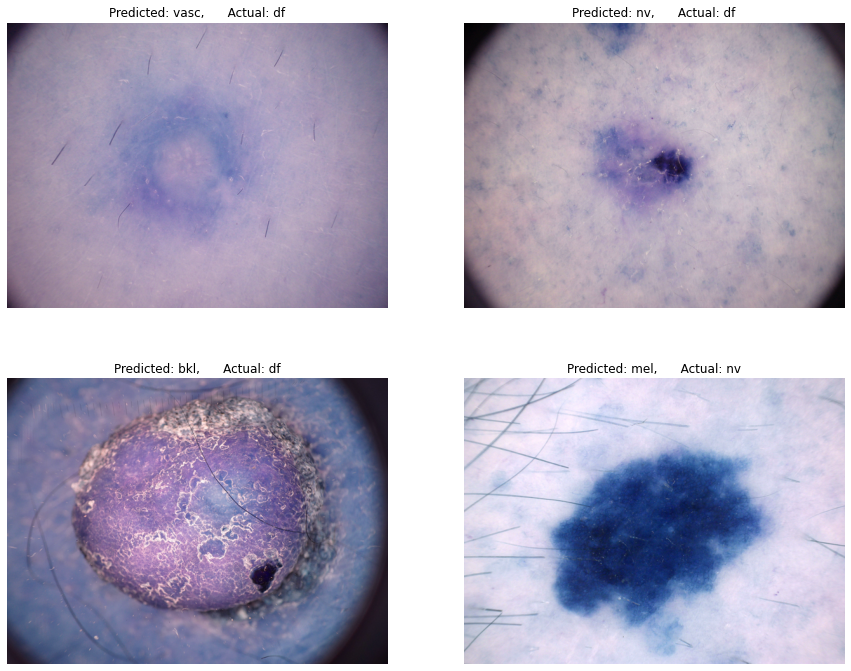

In [ ]:
# Visualizing incorrect predictions
int_to_labels = {0:'akiec', 1:'bcc', 2:'bkl', 3:'df', 4:'mel', 5:'nv', 6:'vasc'}
plt.figure(figsize=(15,12))
for i, id in enumerate(incorrect['image']):
  plt.subplot(2,2,i+1)
  plt.imshow(skin_images[id])
  plt.title('Predicted: ' + int_to_labels[int(incorrect['pred'][i])] +',      Actual: ' + int_to_labels[int(incorrect['actual'][i])])
  plt.axis('off')
plt.show()